# Stylized Facts about Equity Prices

## Math 588: Quantitative Risk Management, Spring 2020
### Professor: Igor Cialenco
### For internal use only. Do not distribute

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import datetime


### Reading Equity Data

In [3]:
# use https://pandas-datareader.readthedocs.io/en/latest/
# pandas_datareader.data.DataReader method to download as dataframe data from yahoo.com
from pandas_datareader import data

SP500 = data.DataReader('^GSPC','yahoo', start='1980-01-01', end='2019-12-31')
SP500.tail() # display last part of data

# create a dataframe with log returns
LRSP500 = pd.DataFrame()
LRSP500['Log Return'] = np.log(SP500['Adj Close']).diff().dropna()

### Key Stats, fitting normals and t-Student 

In [3]:
# Key statistics for Prices
mu_SP500 = SP500['Adj Close'].mean()
sigma_SP500 = SP500['Adj Close'].std()
min_SP500 = SP500['Adj Close'].min()
max_SP500 = SP500['Adj Close'].max()
q05_SP500 = SP500['Adj Close'].quantile(0.05)
q95_SP500 = SP500['Adj Close'].quantile(0.95)
print("Key statistics for Prices")
(print("Mean={0:5.2f}, Std={1:5.2f}, min={2:5.2f}, max={3:5.2f}, q_.05={4:5.2f}, q_.95={5:5.2f}"
       .format(mu_SP500, sigma_SP500, min_SP500, max_SP500, q05_SP500, q95_SP500)))

# simpler is to use describe method for dataframes
keystatsPrices  = SP500.describe()
display(keystatsPrices)

keystatsLogR = LRSP500.describe()
display(keystatsLogR)

mu_LRSP500 = keystatsLogR['Log Return']['mean']
sigma_LRSP500 = keystatsLogR['Log Return']['std']

# fit a Normal and t-Student, 
# i.e. create a time series of Normals and t-Student with same mean and variance as the mean and variance of LogReturnsSP500
from numpy.random import normal
from scipy.stats import t

# to fit/calibrate the t-distribution, use "scipy.stats.t.fit(data)"
# alternativly, fit it manually by matching the variance
t_fit_param = t.fit(LRSP500['Log Return'])
print("t-Student distribution fitted parameters: \ndegrees of freedom=%.6f, mu=%.6f, sigma=%.6f" %t_fit_param)

# add two collumns to the dataframe of logreturns with simulated Normals and t-Student
LRSP500['Fitted Norm'] = normal(mu_LRSP500,sigma_LRSP500,len(LRSP500))
LRSP500['Fitted t'] = t.rvs(*t_fit_param,size=len(LRSP500))

Key statistics for Prices
Mean=999.06, Std=744.57, min=98.22, max=3240.02, q_.05=129.15, q_.95=2600.98


,High,Low,Open,Close,Volume,Adj Close
count,10087.000000,10087.000000,10087.000000,10087.000000,1.008700e+04,10087.000000
mean,1004.571136,992.714297,998.830845,999.058833,1.666173e+09,999.058833
std,747.729578,740.940145,744.498951,744.572446,1.768667e+09,744.572446
min,99.580002,94.230003,98.220001,98.220001,1.499000e+07,98.220001
25%,332.279999,328.419998,330.369995,330.369995,1.723000e+08,330.369995
50%,996.679993,977.489990,987.760010,987.760010,8.803000e+08,987.760010
75%,1379.570007,1360.559998,1369.025024,1369.205017,3.215970e+09,1369.205017
max,3247.929932,3234.370117,3247.229980,3240.020020,1.145623e+10,3240.020020


,Log Return
count,10086.000000
mean,0.000339
std,0.010984
min,-0.228997
25%,-0.004487
50%,0.000548
75%,0.005601
max,0.109572


t-Student distribution fitted parameters: 
degrees of freedom=3.023141, mu=0.000586, sigma=0.006756


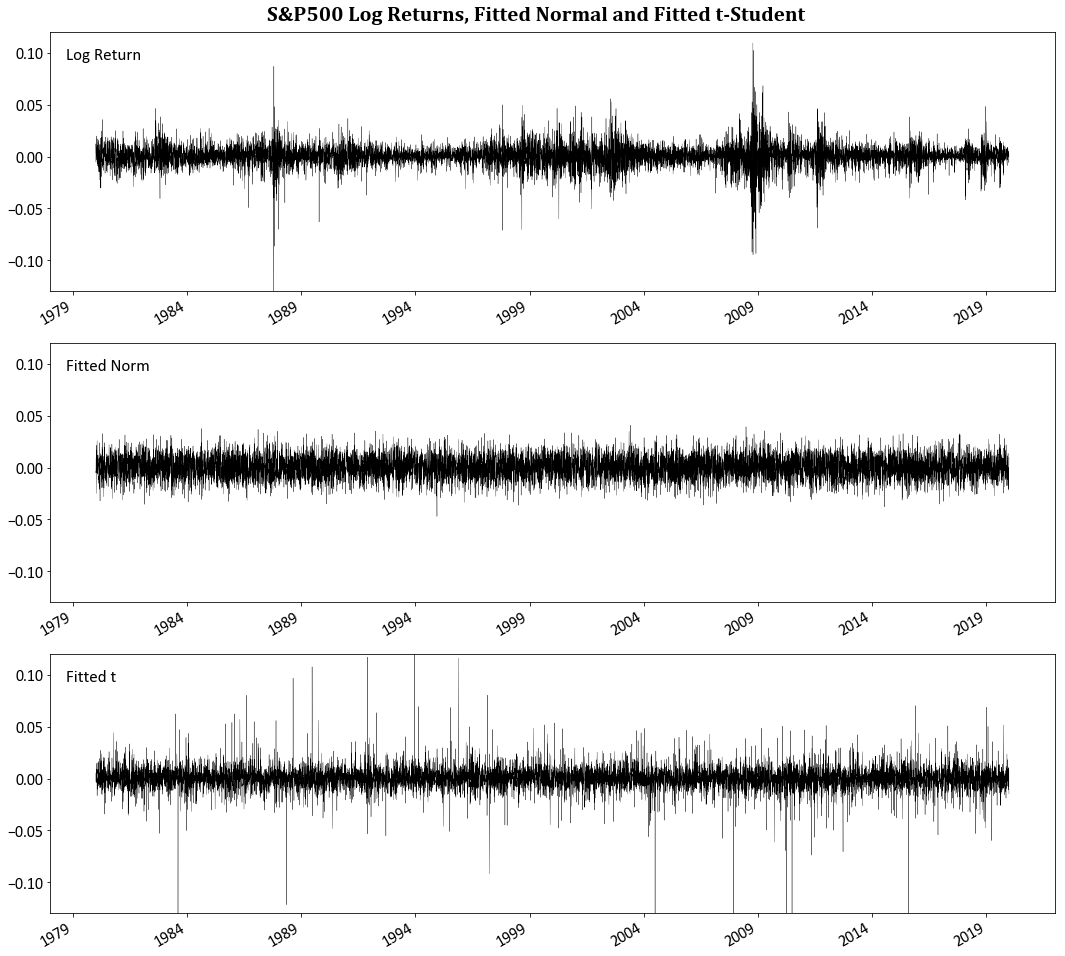

In [4]:
# plot time series of LogReturnsSP500, Fitted Normal and Fitted t-student
# counterpart of Figure 3.1 from [MFE] 

plt.rcParams['font.sans-serif'] = "Calibri"
plt.rcParams['font.family'] = "sans-serif"


# find suitable range for the Y
#ylim = [keystatsLogR.loc['min',:].min(),keystatsLogR.loc['max',:].max()] 
ylim = [-.13, .12]

fig = plt.figure(figsize=(18,18))
(fig.suptitle(u'S&P500 Log Returns, Fitted Normal and Fitted t-Student', 
              y=0.90, fontsize=21, fontname="Cambria", fontweight='normal'))

# use pandas.DataFrame.plot for ploting directly from dataframes
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.html
for i in range(3):
    plt.subplot(3,1,i+1)
    ax = LRSP500.iloc[:,i].plot(ylim=ylim,label=LRSP500.columns[i], lw=.3, fontsize=16, color='black')
    ax.xaxis.label.set_visible(False)
    ax.legend(loc=2,handlelength=0,handletextpad=0,fontsize=17, frameon=False)

#plt.savefig('./figs/SP500LogReturns.eps')
plt.show()

### Correlograms of Log returns, fitted Normal and fitted t-Student (left column) and their correlograms of their absolute values (right panel)

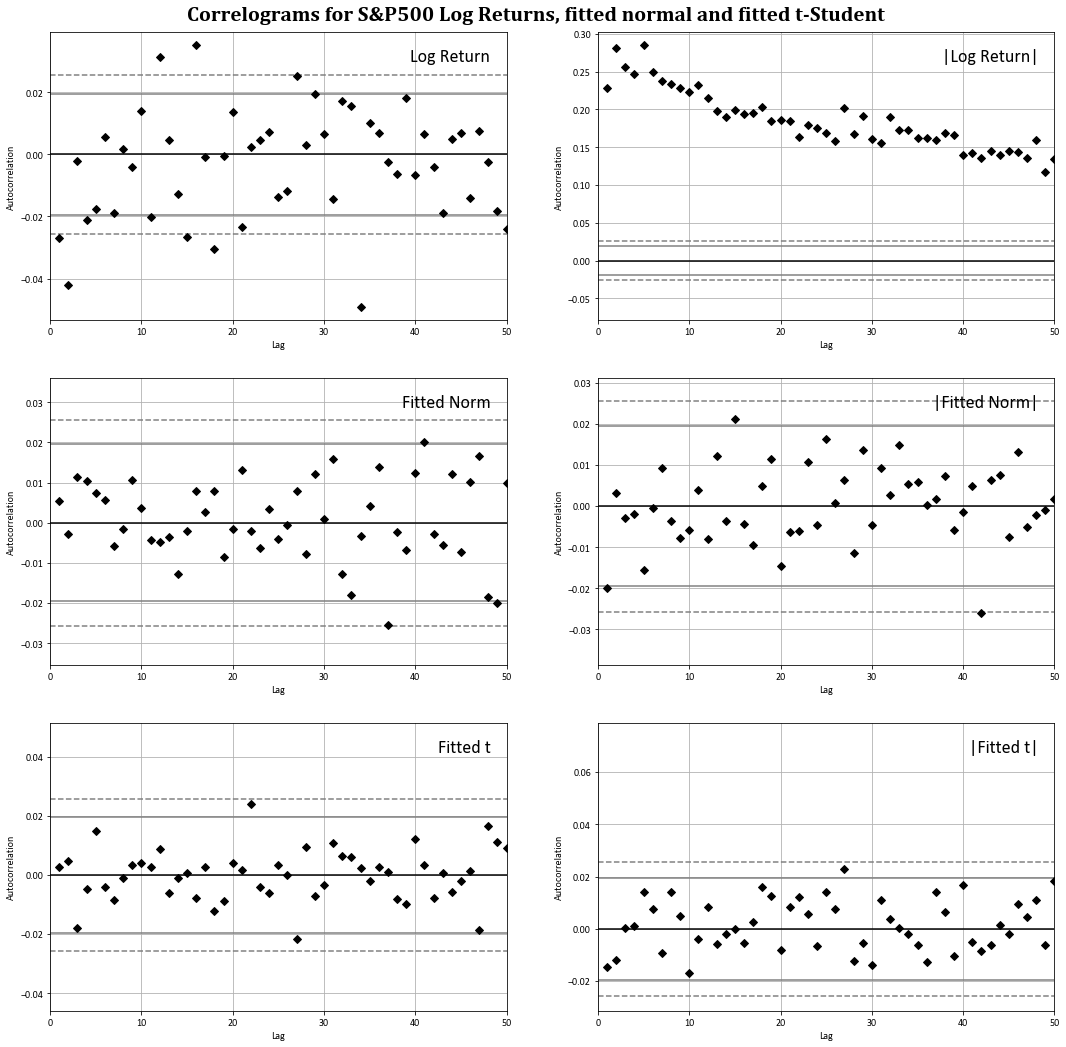

In [5]:
# Correlograms (autocorrelation) of return, fitted normal, fitted t-student and their absolute values
# Counterpart of Figure 3.2 [MFE]

fig = plt.figure(figsize=(18,18))
(fig.suptitle(u'Correlograms for S&P500 Log Returns, fitted normal and fitted t-Student', 
              y=0.90, fontsize=21, fontname="Cambria", fontweight='normal'))

for i in range(6):
    ax = plt.subplot(3,2,i+1)
    data_, legend = [LRSP500.iloc[:,i//2].abs(),'|' + LRSP500.columns[i//2]+'|'] if i%2 \
                else [LRSP500.iloc[:,i//2], LRSP500.columns[i//2]]
    
    pd.plotting.autocorrelation_plot(data_, ax=ax, color='black', linestyle="None", marker='D')
    plt.legend([legend],loc=1,handlelength=0, handletextpad=0, fontsize=18, frameon=False)
    plt.xlim(0, 50)

#plt.savefig('./figs/correlogramSP500.eps')
plt.show()

### Distribution of largest losses and waiting times between big losses

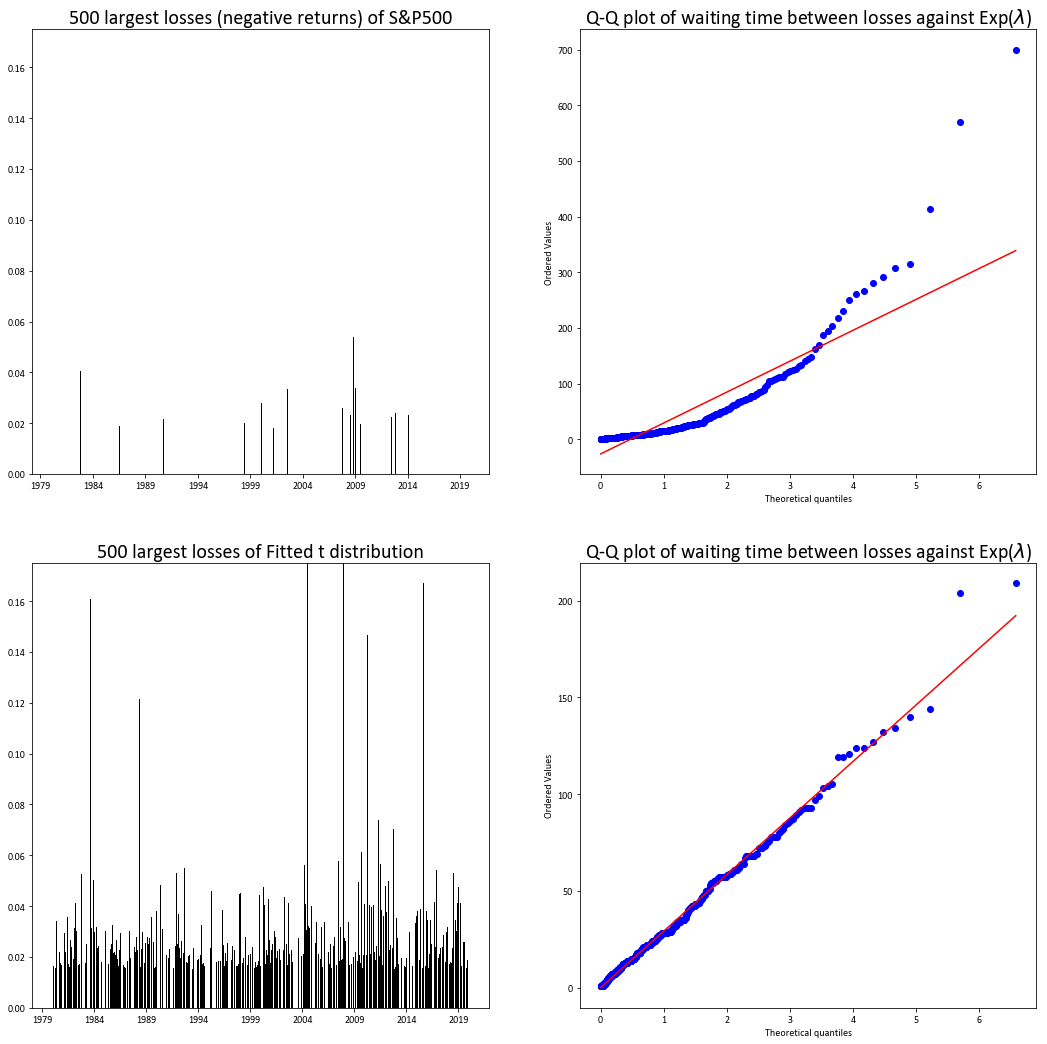

In [6]:
# Find the largest losses (smallest returns) and fit to t-distribution 
# Counterpart of Figure 3.3 in [MFE]
toploss_SP500 = (-LRSP500['Log Return']).nlargest(500).sort_index()
toploss_fittedt = (-LRSP500['Fitted t']).nlargest(500).sort_index()

# waiting times between losses 
timediff_SP500 = toploss_SP500.index.to_series().diff()/ np.timedelta64(1, 'D')
timediff_fittedt = toploss_fittedt.index.to_series().diff()/ np.timedelta64(1, 'D')


plt.figure(figsize=(18,18))

plt.subplot(221)
plt.bar(toploss_SP500.index, height=toploss_SP500.values, color='black')
plt.title('500 largest losses (negative returns) of S&P500',fontsize=20)
plt.ylim(0,0.175)

plt.subplot(222)
stats.probplot(timediff_SP500.dropna(),dist='expon',fit=1,plot=plt)
plt.title(r'Q-Q plot of waiting time between losses against Exp($\lambda$)',fontsize=20)

plt.subplot(223)
plt.bar(x=toploss_fittedt.index,height=toploss_fittedt.values,width=30, color='black')
plt.title('500 largest losses of Fitted t distribution',fontsize=20)
plt.ylim(0,0.175)

plt.subplot(224)
stats.probplot(timediff_fittedt.dropna(),dist='expon',fit=1,plot=plt)
plt.title(r'Q-Q plot of waiting time between losses against Exp($\lambda$)',fontsize=20)

#plt.savefig('./figs/waitingTimesLossSP500.eps')
plt.show()

## Multivaraite Stylized Facts (Section 3.2 [MFE])

In [7]:
# Multivariate stylized facts
# Section 3.3 [MFE]

prices = pd.DataFrame([])
tickers = ['GS', 'BP']
cols = ['r','b']
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

for ticker in tickers:
    prices[ticker] = data.DataReader(ticker, 'yahoo', start_date, end_date)['Adj Close']

LogRets = np.log(prices).diff().dropna()

display(prices.tail())
display(LogRets.tail())


,GS,BP
Date,,
2019-12-24,229.910004,38.040001
2019-12-26,231.210007,37.980000
2019-12-27,230.660004,37.860001
2019-12-30,229.800003,37.599998
2019-12-31,229.929993,37.740002


,GS,BP
Date,,
2019-12-24,0.003573,-0.001838
2019-12-26,0.005638,-0.001579
2019-12-27,-0.002382,-0.003165
2019-12-30,-0.003735,-0.006891
2019-12-31,0.000566,0.003717


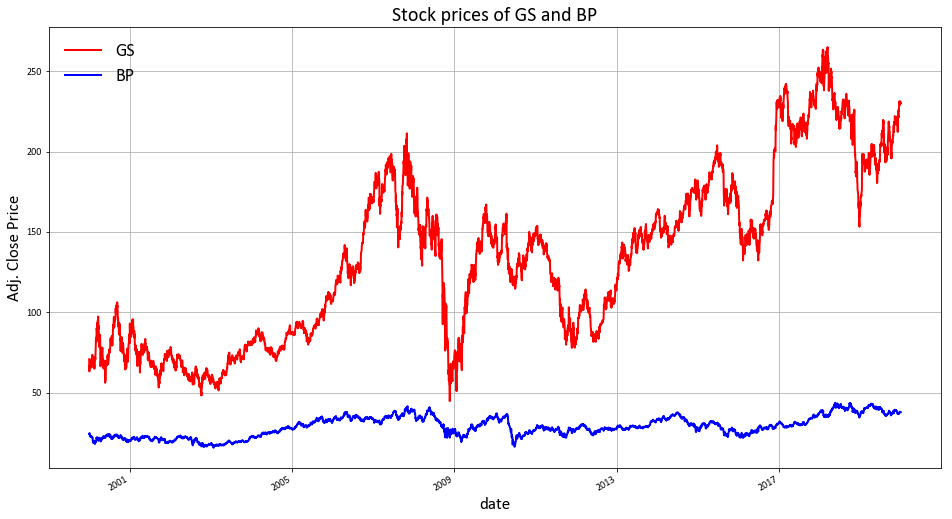

In [8]:
prices.plot(figsize=(16,9),style=cols, lw=2., grid=True)
plt.title('Stock prices of '+ tickers[0]+ ' and ' + tickers[1], fontsize=20,fontweight='normal')
plt.xlabel('date',fontsize=17)
plt.ylabel('Adj. Close Price',fontsize=17)
plt.legend(fontsize=18, frameon=False, loc=2)

#plt.savefig('./figs/prices2Stocks.eps')
plt.show()

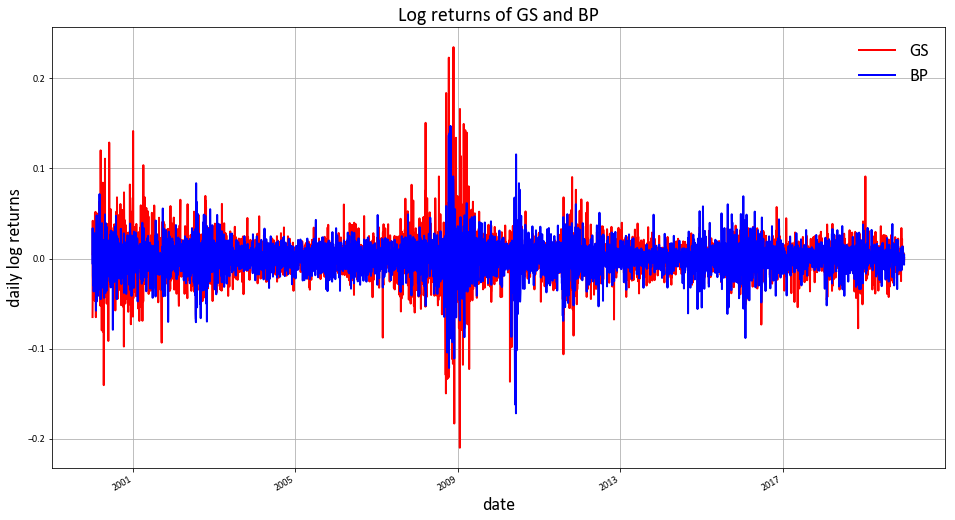

In [9]:
LogRets.plot(figsize=(16,9), style=cols, lw=2., grid=True)
plt.title('Log returns of ' + tickers[0] + ' and ' + tickers[1],fontsize=20,fontweight='normal')
plt.xlabel('date',fontsize=18)
plt.ylabel('daily log returns',fontsize=18)
plt.legend(fontsize=18, frameon=False)
#plt.savefig('./figs/logRets2Stocks.eps')
plt.show()

In [9]:
# find the correlation between returns
print(LogRets[tickers].corr())

          GS        BP
GS  1.000000  0.385762
BP  0.385762  1.000000


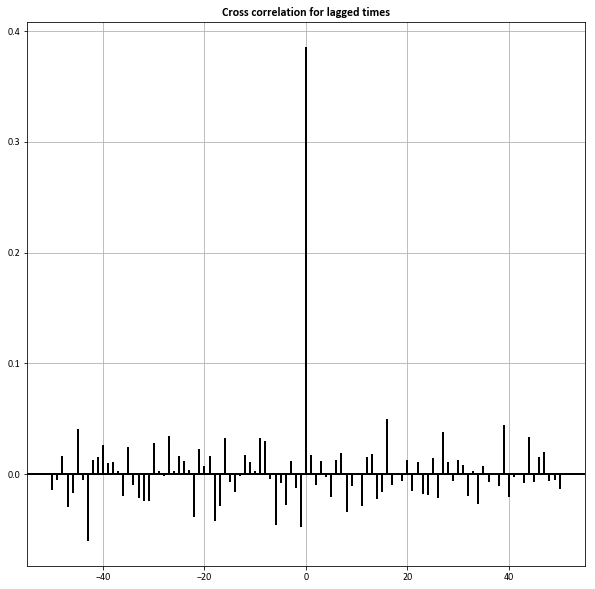

In [10]:
x = LogRets.iloc[:,0]
y = LogRets.iloc[:,1]
#fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
plt.figure(figsize=(10,10))
plt.xcorr(x, y, usevlines=True, maxlags=50, normed=True, lw=2)
plt.title('Cross correlation for lagged times',fontweight='bold')
plt.grid(True)
plt.axhline(0, color='black', lw=2)

#plt.savefig('./figs/crosscorr.eps')
plt.show()

In [11]:
def crosscorr(x, y, lag=0):
    return x.corr(y.shift(lag))

crosscorr(LogRets['GS'], LogRets['BP'], lag=2)

-0.009511345951755172

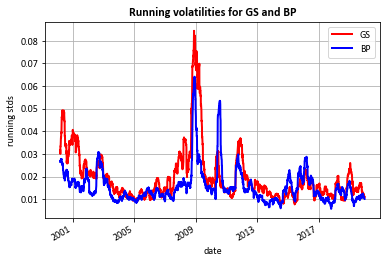

In [12]:
running_std = pd.DataFrame([])
for ticker in tickers:
    running_std[ticker] = LogRets[ticker].rolling(50).std()

running_std.plot(style=cols, lw=2., grid=True)
plt.title('Running volatilities for GS and BP',fontweight='bold')
plt.xlabel('date')
plt.ylabel('running stds')

#plt.savefig('./figs/runningVol2Stocks.eps')
plt.show()

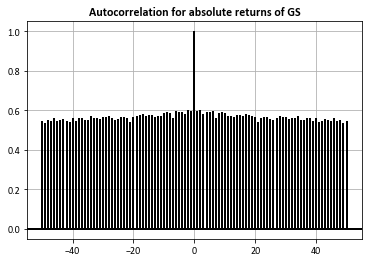

In [14]:
x1 = abs(LogRets).iloc[:,0]
plt.acorr(x1, usevlines=True, normed=True, maxlags=50, lw=2)
plt.grid(True)
plt.axhline(0, color='black', lw=2)
plt.title('Autocorrelation for absolute returns of GS',fontweight='bold')

#plt.savefig('./figs/autocorr.eps')
plt.show()

In [15]:
autocorrelation = []
for ticker in tickers:
    autocorrelation.append(pd.Series.autocorr(abs(LogRets)[ticker],2))
print(autocorrelation)

[0.29359651425836036, 0.2449155507411583]
